# Predicting Fantasy Football Points



In [2]:
import sqlalchemy
from sqlalchemy.orm import create_session
from sklearn import preprocessing
from collections import namedtuple
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='Set2')
%matplotlib inline

In [3]:
engine = sqlalchemy.create_engine('postgresql://localhost/fantasyfootball')    
session = create_session(bind=engine)

In [4]:
class Prediction:

    
    def __init__(self, test_proj_week, position='ALL'):
        self.train_proj_week = test_proj_week - 1
        self.test_proj_week = test_proj_week
        self.position = position


    def make_prediction(self):
        encoders = self.create_position_factors()
        
        self.train_data = self.week_df(self.train_proj_week, encoders.position,
                             encoders.team, self.position)
        test_data = self.week_df(self.test_proj_week, encoders.position, encoders.team, self.position)
        
        clf = RandomForestRegressor(n_estimators=5000, max_depth=5)
        clf.fit(self.train_data.X, self.train_data.y)
        model_predicted_points = clf.predict(test_data.X)
        
        results = self.rmean_sq(test_data.y.values, model_predicted_points)
        espn = self.rmean_sq(test_data.y.values, test_data.espn_proj.values)
        
        # Put some variables in self for easier access
        self.my_prediction = model_predicted_points
        self.model = clf
        self.results = results
        self.espn_results = espn
        self.actual = test_data.y.values
        self.espn_prediction = test_data.espn_proj.values
        
        self.get_combined_df(test_data)
      
    
    def get_combined_df(self, data):
        df=pd.concat([data.X, data.index, data.espn_proj, data.y], axis=1)
        df['name'] = df['index'].str.split("_").str.get(0)
        df['team'] = df['index'].str.split("_").str.get(1)
        df['position'] = df['index'].str.split("_").str.get(2)
        df['my_prediction'] = self.my_prediction
        self.combined_test_df = df
        
    
    def report(self):
        print("Prediction for Week {0} for {1} position(s)".format(self.test_proj_week, self.position))
        print("My RMSE: {}".format(self.results.rmse))
        print("ESPN RMSE: {}".format(self.espn_results.rmse))
        self.plot_feature_importance()
        plt.title("Feature Importance", fontsize=20)
        plt.show()
        self.plot_dist_comp()
        plt.title("Distribution of RMSE", fontsize=20)
        plt.show()
        self.scatter_plot(self.actual, self.my_prediction)
        plt.title("My Predictions", fontsize=20)
        plt.show()
        self.scatter_plot(self.actual, self.espn_prediction)
        plt.title("ESPN Predictions", fontsize=20)
        plt.show()
        
    
    def plot_feature_importance(self):
        plt.figure(figsize=(8,5))
        df = pd.DataFrame()
        df['fi'] = self.model.feature_importances_
        df['name'] = self.train_data.X.columns
        df = df.sort('fi')
        sns.barplot(x=df.name, y=df.fi)
        plt.xticks(rotation='vertical')
        sns.despine()
        
    
    def plot_dist_comp(self):
        plt.figure(figsize=(8,5))
        sns.distplot(self.results.array, label="Me")
        sns.distplot(self.espn_results.array, label="ESPN")
        plt.legend()
        sns.despine()
        
    
    def scatter_plot(self, x, y):
        plt.figure(figsize=(8,5))
        max_v = 40
        x_45 = np.arange(0, max_v)
        plt.scatter(x, y)
        plt.plot(x_45, x_45)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.ylim([0, max_v])
        plt.xlim([0, max_v])
    
    
    def week_df(self, proj_week, position_encoder, team_encoder, position = 'ALL'):
        
        # Get actual data for all previous weeks
        actual_data = pd.read_sql_query("""select name, team, position, opponent, week,
                                    at_home, total_points, won_game, opponent_score, team_score
                                    from scoring_leaders_weekly""", engine)
        
        # Calculate how team's perform on average against positions for fantasy points
        team_data = pd.DataFrame(actual_data.groupby(['opponent', 'position']).total_points.mean())
        team_data.reset_index(level=0, inplace=True)
        team_data.reset_index(level=0, inplace=True)
        team_data.rename(columns={'total_points': 'opponent_points'}, inplace=True)
        actual_data = actual_data.merge(team_data, on=['opponent', 'position'], how='left')
        team_data.rename(columns={'weather': 'competition_sched', 'our_sched': 'stock_report'}, inplace=True)
        
        actual_data['index'] = actual_data.name + "_" + actual_data.team + "_" + actual_data.position
        actual_data.week = actual_data.week.astype(int)
        actual_data = actual_data[actual_data.week < proj_week]

        # Calculate the average values for previous week metrics
        wgt_df = actual_data[['opponent_points', 'index', 'at_home', 'total_points',
                              'won_game', 'opponent_score', 'team_score']]
        group_wgt_df = wgt_df.groupby('index')
        player_df = group_wgt_df.mean()
        player_df.reset_index(level=0, inplace=True)
        
        # Get the opponent data for the next week as well as espn projection
        predicted_data = pd.read_sql_query("""select name, team, position, opponent as next_opponent,
                                            at_home as next_at_home, total_points as predicted_points
                                            from next_week_projections
                                            where week = '{0}'""".format(proj_week), engine)
        predicted_data['index'] = predicted_data.name + "_" + predicted_data.team + "_" + predicted_data.position
        predicted_data.drop(['name', 'team'], axis=1, inplace=True)

        # Start combining everything - messy - sorry...
        X = player_df.merge(predicted_data, on='index', how='left')
        X = X.dropna()

        # Get the actual result as our target
        actual_result = pd.read_sql_query("""select name, team, position, total_points as actual_points
                                            from scoring_leaders_weekly
                                            where week = '{0}'""".format(proj_week), engine)
        actual_result['index'] = actual_result.name + "_" + actual_result.team + "_" + actual_result.position
        actual_result.drop(['name', 'team', 'position'], axis=1, inplace=True)

        X = X.merge(actual_result, on='index', how='left')
        X = X.merge(team_data, on=['position', 'next_opponent'], how='left')
        X = X.dropna()
        if position != 'ALL':
            X = X[X.position == position]
        y = X.actual_points

        X['team'] = X['index'].str.split("_").str.get(1)

        # Sklearn won't create factors for you, so encode the categories to integers
        X['team_factor'] = team_encoder.transform(X.team)
        if position == 'ALL':
            X['position_factor'] = position_encoder.transform(X.position)
        X['next_opponent_factor'] = team_encoder.transform(X.next_opponent)

        espn = X['predicted_points']
        index = X['index']
        X.drop(['predicted_points', 'actual_points', 'team', 'position', 'next_opponent', 'index'], axis=1, inplace=True)
        
        # Return named tuple of all the data I need
        week_tuple = namedtuple('Week', ['X', 'y', 'espn_proj', 'index'])
        return week_tuple(X, y, espn, index)
    
    
    def create_position_factors(self):
        # Convert positions into integer categories
        position_encoder = preprocessing.LabelEncoder()
        positions = np.ravel(pd.read_sql_query("""select distinct position from scoring_leaders_weekly;""", engine).values)
        position_encoder.fit(positions)

        # Convert team names into integer categories
        team_encoder = preprocessing.LabelEncoder()
        teams = np.ravel(pd.read_sql_query("""select distinct team from scoring_leaders_weekly;""", engine).values)
        team_encoder.fit(teams)
        encoders = namedtuple('encoders', ['team', 'position'])
        return encoders(team_encoder, position_encoder)
    
    
    def rmean_sq(self, y_true, y_pred):
        rmse = namedtuple('rmse', ['rmse', 'array'])
        sq_error = []
        assert len(y_true) == len(y_pred)
        for i in range(len(y_true)):
            sq_error.append((y_true[i] - y_pred[i])**2)
        return rmse(np.sqrt(np.mean(sq_error)), np.sqrt(sq_error))

In [5]:
week_3_proj_all = Prediction(3)
week_3_proj_all.make_prediction()
week_3_proj_all.report()

OperationalError: (psycopg2.OperationalError) fe_sendauth: no password supplied
 (Background on this error at: http://sqlalche.me/e/e3q8)

In [5]:
data = week_3_proj_all.combined_test_df
data['my_error'] = np.sqrt((data['my_prediction'] - data['actual_points'])**2)
data['espn_error'] = np.sqrt((data['predicted_points'] - data['actual_points'])**2)
data = data[['position', 'my_error', 'espn_error']]
data = pd.melt(data, id_vars=['position'], value_vars=['my_error', 'espn_error'])
data.columns = ['position', 'type', 'error']

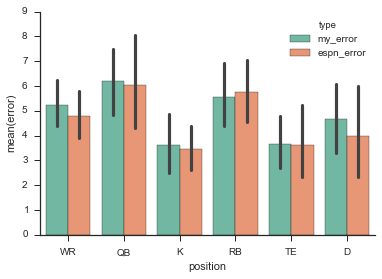

In [6]:
sns.barplot(x='position', y='error', hue='type', data=data)
sns.despine()==

In [1]:
import plotly.plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np

cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

df = pd.DataFrame(np.random.rand(10, 4), columns=['A', 'B', 'C', 'D'])
row = df.ix[5]
row.iplot(kind='bar', filename='cufflinks/bar-chart-row')

/home/amarsrinivas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

In [3]:
import plotly.plotly as py
import cufflinks as cf
import pandas as pd

cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

df = pd.read_csv('https://raw.githubusercontent.com/plotly/widgets/master/ipandas-examples/311_150k.csv', parse_dates=True, index_col=1)
df.head(3)

series = df['Complaint Type'].value_counts()[:20]
series.head(3)

series.iplot(kind='bar', yTitle='Number of Complaints', title='NYC 311 Complaints',
             filename='cufflinks/categorical-bar-chart')

HTTPError: HTTP Error 404: Not Found

In [11]:
# importing matplotlib 
import matplotlib.pyplot as plt
  
# importing pandas as pd 
import pandas as pd 
  
# importing numpy as np 
import numpy as np 
  
# creating a dataframe  
df = pd.DataFrame(np.random.rand(10, 4), columns =['weather', 'competition', 'Estee', 'Stock Report']) 
  

In [12]:
print(df)

    weather  competition     Estee  Stock Report
0  0.401996     0.344188  0.348908      0.312022
1  0.036561     0.224782  0.772338      0.248240
2  0.817719     0.940528  0.501686      0.679366
3  0.152516     0.980193  0.628684      0.342727
4  0.310151     0.718046  0.189868      0.087431
5  0.172017     0.675668  0.971218      0.927866
6  0.085748     0.446864  0.731766      0.263948
7  0.753052     0.449407  0.736328      0.653229
8  0.244946     0.005062  0.091908      0.834013
9  0.778701     0.920271  0.517953      0.600422


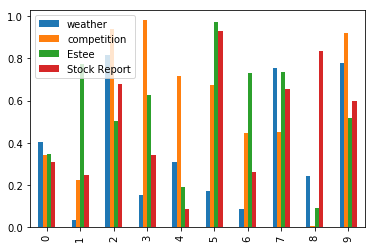

<Figure size 1440x720 with 0 Axes>

In [15]:
df.plot.bar() 
fig= plt.figure(figsize=(20,10))

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

(-2.740770608255631, 2.581773841963696, -0.9503241913662932, 1.022119864077601)

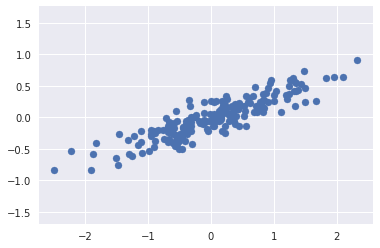

In [19]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [21]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [22]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


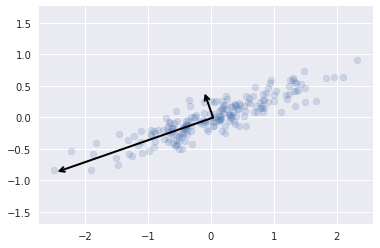

In [23]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

In [24]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


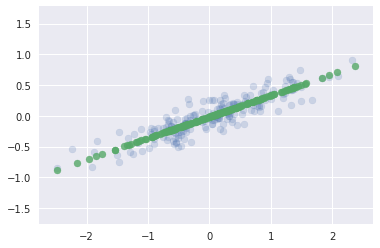

In [25]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

In [26]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [27]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


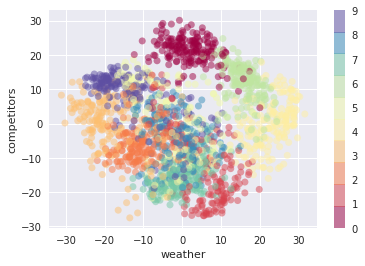

In [31]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('weather')
plt.ylabel('competitors')
plt.colorbar();